# 1.模型训练

In [8]:
import pandas as pd
from tqdm import tqdm


# def get_tags(label, length):
#     tags = ['O'] * length
#     for entity_type, [start, end] in label:
#         entity_type = entity_type[0:3]
#         tags[start] = 'B-' + entity_type
#         for i in range(start+1, end)l:
#             tags[i] = 'I-' + entity_type
#     return tags


def get_tags(label, tokens):
    length = len(tokens)
    tags = ['O'] * length
    index = []*length
    last = 0
    for i in range(length):
        index.append(last+len(tokens[i]))
        last = index[-1]+1
#     print(index)
    label.sort(key = lambda x: x[1][0])
    help_map = {0:'B-', 1:'I-'}
#     print(label)
    label2 = [(l, x[0:3]) for x, y in label for l in y]
#     print(label2)
    i, j = 0, 0
    while i < length and j < len(label):    # 双指针
        if label[j][1][0] < index[i] <= label[j][1][1]:
            tags[i] = label[j][0][0:3]
        if index[i] > label[j][1][1]:
            j += 1
            i -= 1
        i += 1
    for i in range(length-1, -1, -1):
        if tags[i] != 'O':
            if i == 0 or tags[i-1] != tags[i]:
                tags[i] = f'B-{tags[i]}'
            else:
                tags[i] = f'I-{tags[i]}'
    return tags


def read(file):
    df = pd.read_json(file)
    data_size = len(df)
    data_set = {'training': [], 'test': []}
    word_to_ix = {'$unk#': 0}
    # word_to_ix = {}
    for i in tqdm(range(0, data_size//5*4), desc='读取训练数据', position=0):
        text, label = df.loc[i]
        tokens = text.split()
        tags = get_tags(label, tokens)
        for word in tokens:
            if word not in word_to_ix:
                word_to_ix[word] = len(word_to_ix)
        data_set['training'].append((tokens, tags))
    for i in tqdm(range(data_size//5*4, data_size), desc='读取测试数据', position=0):
        text, label = df.loc[i]
        tokens = text.split()
        tags = get_tags(label, tokens)
        for word in tokens:
            if word not in word_to_ix:
                word_to_ix[word] = len(word_to_ix)
        data_set['test'].append((tokens, tags))
    # print(len(data_set['training']))
    # print(len(data_set['test']))
#     length = len(word_to_ix) - 1
#     for k, v in word_to_ix.items():
#         word_to_ix[k] = v / length
    return data_set, word_to_ix

# read('./data/data.json')[1]

In [12]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim


torch.manual_seed(1)    # 人工设定随机种子以保证相同的初始化参数，实现模型的可复现性。
START_TAG = "<START>"
STOP_TAG = "<STOP>"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# torch.set_default_tensor_type(torch.cuda.LongTensor)

def argmax(vec):  # 给定输入二维序列，取每行（第一维度）的最大值，返回对应索引。
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


def prepare_sequence(seq, to_ix):   # 利用to_ix映射，将词序列转化为下标序列，并转成张量
    idxs = [to_ix.get(w, 0) for w in seq]
    # idxs = [to_ix[w] for w in seq]
#     return torch.Tensor(idxs)
    return torch.tensor(idxs, dtype=torch.long)


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):   # 函数目的相当于log∑exi(首先取序列中最大值，输入序列是一个二维序列(
    # shape[1,tags_size])。下面的计算先将每个值减去最大值，再取log_sum_exp，最后加上最大值)
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))


# def compute_loss(self, pre, target):
#     loss_func = torch.nn.SmoothL1Loss()
#     loss = [loss_func(x, y) for x, y in zip(pre, target)]
#     plt.rcParams['figure.figsize'] = (5.0, 4.0)  # 设置图像显示大小
#     plt.rcParams['image.interpolation'] = 'nearest'  # 设置差值方式
#     plt.rcParams['image.cmap'] = 'gray'  # 设置灰度空间
#     plt.plot(np.squeeze(loss))
#     plt.ylabel('loss')
#     plt.xlabel('iterations (per tens)')
#     plt.title("Learning rate = 0.01")
#     plt.show()


class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim  # 词嵌入维度，即输入维度
        self.hidden_dim = hidden_dim  # 隐层维度
        self.vocab_size = vocab_size  # 训练集词典大小
        self.tag_to_ix = tag_to_ix  # 标签索引表
        self.tagset_size = len(tag_to_ix)  # 标注 类型数
#         print(f'tagset_size={self.tagset_size}')
        self.word_embeds = nn.Embedding(vocab_size,
                                        embedding_dim).cuda()  # （词嵌入的个数，嵌入维度）
        self.lstm = nn.LSTM(embedding_dim, hidden_dim//2,
                            # （输入节点数，隐层节点数，隐层层数，是否双向）
                            num_layers=1,
                            bidirectional=True).cuda()  # hidden_size除以2是为了使BiLSTM
#         self.lstm.to(device)
        # 的输出维度依然是hidden_size,而不用乘以2

        # Maps the output of the LSTM into tag space.
        # （输入x的维度，输出y的维度），将LSTM的输出线性映射到标签空间
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size).cuda()

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(  # 转移矩阵，标注j转移到标注i的概率，后期要学习更新
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000  # 不会有标注转移到开始标注
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000  # 结束标注不会转移到其他标注

        self.hidden = self.init_hidden()

    def init_hidden(self):  # 初始化隐层（两层，3维）
        # (num_layer * num_direction, batch_size)
        # (隐层层数2 * 方向数1， 批大小1， 每层节点数)
        return (torch.randn(2, 1, self.hidden_dim//2).cuda(),
                torch.randn(2, 1, self.hidden_dim//2).cuda())

    def _forward_alg(self, feats):  # 得到所有路径的分数/概率
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size),
                                 -10000.).cuda()  # P，(1, m)维，初始化为-10000
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas  # 前向状态，记录当前t之前的所有路径的分数

        # Iterate through the sentence
        for feat in feats:  # 动态规划思想，具体见onenote上的笔记
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(1, -1).expand(1,
                                                               self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var+trans_score+emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var+self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha  # 返回的是所有路径的分数

    def _get_lstm_features(self, sentence):  # 通过BiLSTM层，输出得到发射分数
        self.hidden = self.init_hidden()
        # 对输入语句 词嵌入化
        sentence = sentence.cuda()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1).cuda()
        # 词嵌入通过lstm网络输出,lstm传入参数之后会自动调用其forward方法
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        # 将输出转为2维（原本是3维，但是batch_size=1，可以去掉这一维）
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)  # 将输出映射到标签空间，得到单词-分数表
#         print(torch.nn.Softmax(dim=0)(lstm_feats))
        return torch.nn.Softmax(dim=1)(lstm_feats).cuda()

    def _score_sentence(self, feats, tags):  # 计算给定路径的分数
        # feats : LSTM的所有输出，发射分数矩阵
        # tags : golden路径的标注序列
        # Gives the score of a provided tag sequence
        score = torch.zeros(1).cuda()
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).cuda(),tags])  # 在标注序列最前加上开始标注
#         tags = torch.cat([torch.Tensor([self.tag_to_ix[START_TAG]]),tags])  # 在标注序列最前加上开始标注
        for i, feat in enumerate(feats):  # 计算给定序列的分数，Σ发散分数+Σ转移分数
            score = score+self.transitions[tags[i+1], tags[i]]+feat[tags[i+1]]
        score = score+self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        print('-----cc---------')
        backpointers = []

        # Initialize the viterbi variables in log space
        # 初始化forward_var,并且 开始标注 的分数为0,确保一定是从START_TAG开始的,
        init_vvars = torch.full((1, self.tagset_size), -10000.)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        # forward_var记录每个标签的前向状态得分，即w{i-1}被打作每个标签的对应得分值
        forward_var = init_vvars

        # feats是LSTM的输出，每一个feat都是一个词w{i}，feat[tag]就是这个词tag标注的分数
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step记录当前词w{i}对应每个标签的最优转移结点
            viterbivars_t = []  # holds the viterbi variables for this step 记录当前词各个标签w{i, j}对应的最高得分
            # 动态规划：w{i，j}=max{forwar_var + transitions[j]}，词存于bptrs_t中，分数存于viterbivars_t中

            for next_tag in range(self.tagset_size):  # 对当前词w{i}的每个标签 运算
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var+self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t)+feat).view(1, -1)
            backpointers.append(bptrs_t)  # 记忆，方便回溯

        # Transition to STOP_TAG
        terminal_var = forward_var+self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)  # 结束标记前的一个词的最高前向状态得分就是最优序列尾
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):  # 回溯
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, tags):  # CRF的损失函数：-gold分数-logsumexp(所有序列)
        feats = self._get_lstm_features(
            sentence)  # 通过BiLSTM层，获得每个 {词-标签}对 的发射分数
        forward_score = self._forward_alg(feats)  # 根据发射分数计算所有路径的分数
        gold_score = self._score_sentence(feats, tags)  # 传入标注序列真实值，计算语句的真实分数gold_score
        return forward_score-gold_score  # 返回误差值

    def forward(self, sentence):  # 重载前向传播函数，对象传入参数后就会自动调用该函数
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence)  # 通过LSTM层得到输出

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)  # 通过CFR层得到最优路径及其分数
        return score, tag_seq

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from tqdm.notebook import trange
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import random

# from bilstm_crf import *
# from read_data import read


START_TAG = "<START>"
STOP_TAG = "<STOP>"
EMBEDDING_DIM = 5  # 词嵌入维度
HIDDEN_DIM = 4  # 隐层层数
tag_to_ix = {  # 标签词典 {标注——索引}
    "B-NAM": 0, "B-TIC": 1, "B-NOT": 2,
    "I-NAM": 3, "I-TIC": 4, "I-NOT": 5,
    "O": 6, START_TAG: 7, STOP_TAG: 8
}
data_set, word_to_ix = read('./data/data.json')  # 数据集，词典 {词——索引}

读取训练数据:   0%|          | 0/2400 [00:00<?, ?it/s]

读取测试数据:   0%|          | 0/600 [00:00<?, ?it/s]

In [14]:

def compute_loss(pre, target):
    loss_func = torch.nn.SmoothL1Loss()
    loss = [loss_func(x, y) for x, y in zip(pre, target)]
    plt.rcParams['figure.figsize'] = (5.0, 4.0)  # 设置图像显示大小
    plt.rcParams['image.interpolation'] = 'nearest'  # 设置差值方式
    plt.rcParams['image.cmap'] = 'gray'  # 设置灰度空间
    plt.plot(np.squeeze(loss))
    plt.ylabel('loss')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate = 0.02")
    plt.show()


# def add_batch(data_input, data_label, batch_size):
#     print(data_label)
#     data_input = torch.Tensor(data_input)
#     data_label = torch.Tensor(data_label)
# #     print(len(data_input))
# #     print(len(data_label))
#     data = TensorDataset(data_input, data_label)
#     data_loader = DataLoader(data, batch_size=batch_size, shuffle=False) #shuffle是是否打乱数据集，可自行设置

#     return data_loader


def train():
    # data_set, word_to_ix = read('./data/data.json')  # 数据集，词典 {词——索引}
    training_data = data_set['training']

    model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM).cuda()
    model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.05, weight_decay=1e-4)
#     data_in, data_label = [], []
#     for tokens, tags in training_data:
#         data_in.append(tokens)
#         data_label.append(tags)
#     training_batch = add_batch(data_in, data_label, 100)
    # Make sure prepare_sequence from earlier in the LSTM section is loaded
    for epoch in trange(300, desc='模型训练进度'):
        bar = tqdm(enumerate(training_data), leave=False)
        for step, (tokens, tags) in bar:
            tokens_unk = tokens[:]
            tokens_unk[random.randrange(len(tokens))] = '$unk#'
            bar.set_description(f'epoch【{epoch}】')
            for sentence in [tokens, tokens_unk]:
                # Step 1. Remember that Pytorch accumulates gradients.
                # We need to clear them out before each instance
                model.zero_grad()

                # Step 2. Get our inputs ready for the network, that is,
                # turn them into Tensors of word indices.
                sentence_in = prepare_sequence(sentence, word_to_ix)
                targets = torch.tensor([tag_to_ix[t] for t in tags],
                                       dtype=torch.long)
                sentece_in = sentence_in.to(device)
                targets = targets.to(device)
#                 targets = torch.Tensor([tag_to_ix[t] for t in tags])

                # Step 3. Run our forward pass.
                loss = model.neg_log_likelihood(sentence_in, targets)

                # Step 4. Compute the loss, gradients, and update the parameters by
                # calling optimizer.step()
                loss.backward()
                optimizer.step()
            if epoch % 10 == 0: # https://blog.csdn.net/u013250861/article/details/124657801
                state = {
                    'epoch' : epoch + 1,                  # 保存当前的迭代次数
                    'state_dict' : model.state_dict(),    # 保存模型参数
                    'optimizer' : optimizer.state_dict(), # 保存优化器参数
                }
                torch.save(state, f'./checkpoint3/checkpoint{epoch}.pth.tar')
    print('training over!')
    torch.save(model, 'pre_model.pth')
    torch.save(model.state_dict(), 'model_params.pth')
    
train()

tagset_size=9


模型训练进度:   0%|          | 0/300 [00:00<?, ?it/s]

0it [00:00, ?it/s]

KeyboardInterrupt: 

In [ ]:
# GPU利用率低 https://blog.csdn.net/stay_zezo/article/details/107809409

# 2.模型测试

In [29]:
import pandas as pd
from tqdm import tqdm


# def get_tags(label, length):
#     tags = ['O'] * length
#     for entity_type, [start, end] in label:
#         entity_type = entity_type[0:3]
#         tags[start] = 'B-' + entity_type
#         for i in range(start+1, end):
#             tags[i] = 'I-' + entity_type
#     return tags


def get_tags(label, tokens):
    length = len(tokens)
    tags = ['O'] * length
    index = []*length
    last = 0
    for i in range(length):
        index.append(last+len(tokens[i]))
        last = index[-1]+1
#     print(index)
    label.sort(key = lambda x: x[1][0])
    help_map = {0:'B-', 1:'I-'}
#     print(label)
    label2 = [(l, x[0:3]) for x, y in label for l in y]
#     print(label2)
    i, j = 0, 0
    while i < length and j < len(label):    # 双指针
        if label[j][1][0] < index[i] <= label[j][1][1]:
            tags[i] = label[j][0][0:3]
        if index[i] > label[j][1][1]:
            j += 1
            i -= 1
        i += 1
    for i in range(length-1, -1, -1):
        if tags[i] != 'O':
            if i == 0 or tags[i-1] != tags[i]:
                tags[i] = f'B-{tags[i]}'
            else:
                tags[i] = f'I-{tags[i]}'
    return tags


def read(file):
    df = pd.read_json(file)
    data_size = len(df)
    data_set = {'training': [], 'test': []}
    word_to_ix = {'$unk#': 0}
    # word_to_ix = {}
    for i in tqdm(range(0, data_size//5*4), desc='读取训练数据', position=0):
        text, label = df.loc[i]
        tokens = text.split()
        tags = get_tags(label, tokens)
        for word in tokens:
            if word not in word_to_ix:
                word_to_ix[word] = len(word_to_ix)
        data_set['training'].append((tokens, tags))
    for i in tqdm(range(data_size//5*4, data_size), desc='读取测试数据', position=0):
        text, label = df.loc[i]
        tokens = text.split()
        tags = get_tags(label, tokens)
        for word in tokens:
            if word not in word_to_ix:
                word_to_ix[word] = len(word_to_ix)
        data_set['test'].append((tokens, tags))
#     print(len(data_set['training']))
#     print(len(data_set['test']))
    return data_set, word_to_ix

data_set, word_to_ix = read('./data/data.json')

读取测试数据: 100%|███████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 14673.69it/s]


In [40]:
from bilstm_crf import *
import torch
def test():
    test_data = data_set['test']
    length = len(test_data)
#     epoch_times = 240
    for epoch_times in range(150, 290, 50):
        checkpoint = torch.load(f'./checkpoint2/checkpoint{epoch_times}.pth.tar')
        pre_model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM)
        pre_model.load_state_dict(checkpoint['state_dict'])
    #     pre_model = torch.load('pre_model.pth')  # 直接加载模型
        pre = []
        targets = []
        with torch.no_grad():
            for i in range(length):
                tokens, tags = test_data[i]
                # print(test_data[i])
                # print(' '.join(tokens), end=' ')
                # print(tags)
                model_in = prepare_sequence(tokens, word_to_ix)
                model_out = pre_model(model_in)
                # print(model_in, end=' ')
                # print(model_out)
                # print(f'模型预测输出: {model_out}')
                target = torch.Tensor([tag_to_ix[tag] for tag in tags])
                pre.append(torch.Tensor(model_out[1]))
                targets.append(target)
    #     print(targets)
    #     print('====================')
    #     print(pre)
        compute_loss(pre, targets, epoch_times)


In [41]:
def compute_loss(pre, target, e):
    loss_func = torch.nn.SmoothL1Loss()
#     print([(x, y) for x, y in zip(pre, target)][0:10])
    loss = [loss_func(x, y) for x, y in zip(pre, target)]
#     print(np.sum(np.squeeze(loss)))
    plt.rcParams['figure.figsize'] = (9.0, 5.0)  # 设置图像显示大小
    plt.rcParams['image.interpolation'] = 'nearest'  # 设置差值方式
    plt.rcParams['image.cmap'] = 'gray'  # 设置灰度空间
    plt.plot(np.squeeze(loss))
    plt.ylabel('loss')
    plt.xlabel('test   data')
    plt.title(f"Learning rate = 0.05,    epoch_times = {e}")
    plt.show()

tagset_size=9


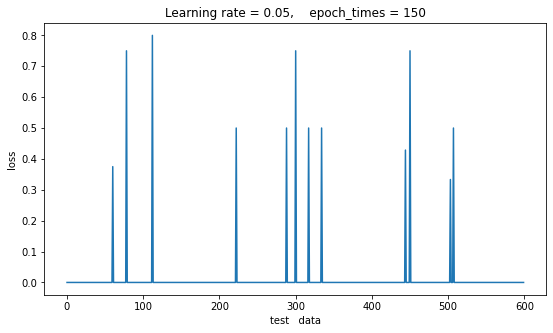

tagset_size=9


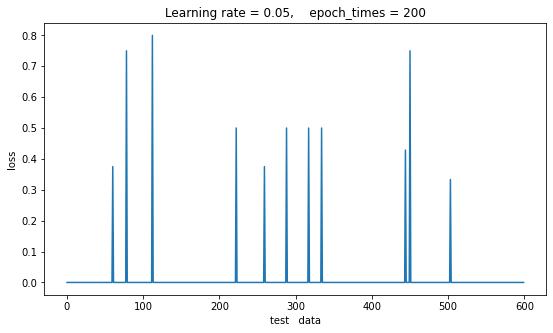

tagset_size=9


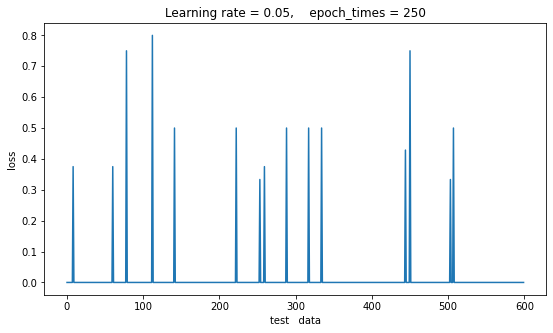

In [42]:
test()

In [52]:
def compute_loss(pre, target):
    loss_func = torch.nn.SmoothL1Loss()
#     print([(x, y) for x, y in zip(pre, target)][0:10])
    loss = [loss_func(x, y) for x, y in zip(pre, target)]
    print(np.sum(np.squeeze(loss)))
    plt.rcParams['figure.figsize'] = (9.0, 6.0)  # 设置图像显示大小
    plt.rcParams['image.interpolation'] = 'nearest'  # 设置差值方式
    plt.rcParams['image.cmap'] = 'gray'  # 设置灰度空间
    plt.plot(np.squeeze(loss))
    plt.ylabel('loss')
    plt.xlabel('test   data')
    plt.title(f"Learning rate = 0.05,    epoch_times = 300")
    plt.show()

In [55]:
import torch
def test():
    test_data = data_set['test']
    length = len(test_data)
    epoch_times = 240
    loss_change = []
    for epoch_times in tqdm(range(0,300,10), position = 0):
        checkpoint = torch.load(f'./checkpoint2/checkpoint{epoch_times}.pth.tar')
        pre_model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM)
        pre_model.load_state_dict(checkpoint['state_dict'])
        print(f'./checkpoint2/checkpoint{epoch_times}.pth.tar')
        print(pre_model)
    #     pre_model = torch.load('pre_model.pth')  # 直接加载模型
        pre = []
        targets = []
        with torch.no_grad():
            for i in range(length):
                tokens, tags = test_data[i]
                model_in = prepare_sequence(tokens, word_to_ix)
                model_out = pre_model(model_in)
                # print(model_in, end=' ')
                # print(model_out)
                # print(f'模型预测输出: {model_out}')
                target = torch.Tensor([tag_to_ix[tag] for tag in tags])
                pre.append(torch.Tensor(model_out[1]))
                targets.append(target)
        loss_func = torch.nn.SmoothL1Loss()
        loss = [loss_func(x, y) for x, y in zip(pre, target)]
        loss_change.append(np.sum(np.squeeze(loss)))
    print(loss_change)

test()

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

tagset_size=9
./checkpoint2/checkpoint0.pth.tar
BiLSTM_CRF(
  (word_embeds): Embedding(4271, 5)
  (lstm): LSTM(5, 2, bidirectional=True)
  (hidden2tag): Linear(in_features=4, out_features=9, bias=True)
)


  3%|██▊                                                                                | 1/30 [00:01<00:49,  1.70s/it]

tagset_size=9
./checkpoint2/checkpoint10.pth.tar
BiLSTM_CRF(
  (word_embeds): Embedding(4271, 5)
  (lstm): LSTM(5, 2, bidirectional=True)
  (hidden2tag): Linear(in_features=4, out_features=9, bias=True)
)


  7%|█████▌                                                                             | 2/30 [00:04<01:00,  2.17s/it]

tagset_size=9
./checkpoint2/checkpoint20.pth.tar
BiLSTM_CRF(
  (word_embeds): Embedding(4271, 5)
  (lstm): LSTM(5, 2, bidirectional=True)
  (hidden2tag): Linear(in_features=4, out_features=9, bias=True)
)


 10%|████████▎                                                                          | 3/30 [00:05<00:48,  1.81s/it]

tagset_size=9
./checkpoint2/checkpoint30.pth.tar
BiLSTM_CRF(
  (word_embeds): Embedding(4271, 5)
  (lstm): LSTM(5, 2, bidirectional=True)
  (hidden2tag): Linear(in_features=4, out_features=9, bias=True)
)


 13%|███████████                                                                        | 4/30 [00:06<00:40,  1.54s/it]

tagset_size=9
./checkpoint2/checkpoint40.pth.tar
BiLSTM_CRF(
  (word_embeds): Embedding(4271, 5)
  (lstm): LSTM(5, 2, bidirectional=True)
  (hidden2tag): Linear(in_features=4, out_features=9, bias=True)
)


 17%|█████████████▊                                                                     | 5/30 [00:07<00:34,  1.39s/it]

tagset_size=9
./checkpoint2/checkpoint50.pth.tar
BiLSTM_CRF(
  (word_embeds): Embedding(4271, 5)
  (lstm): LSTM(5, 2, bidirectional=True)
  (hidden2tag): Linear(in_features=4, out_features=9, bias=True)
)


 20%|████████████████▌                                                                  | 6/30 [00:10<00:42,  1.76s/it]

tagset_size=9
./checkpoint2/checkpoint60.pth.tar
BiLSTM_CRF(
  (word_embeds): Embedding(4271, 5)
  (lstm): LSTM(5, 2, bidirectional=True)
  (hidden2tag): Linear(in_features=4, out_features=9, bias=True)
)


 23%|███████████████████▎                                                               | 7/30 [00:12<00:41,  1.80s/it]

tagset_size=9
./checkpoint2/checkpoint70.pth.tar
BiLSTM_CRF(
  (word_embeds): Embedding(4271, 5)
  (lstm): LSTM(5, 2, bidirectional=True)
  (hidden2tag): Linear(in_features=4, out_features=9, bias=True)
)


 27%|██████████████████████▏                                                            | 8/30 [00:13<00:35,  1.60s/it]

tagset_size=9
./checkpoint2/checkpoint80.pth.tar
BiLSTM_CRF(
  (word_embeds): Embedding(4271, 5)
  (lstm): LSTM(5, 2, bidirectional=True)
  (hidden2tag): Linear(in_features=4, out_features=9, bias=True)
)


 30%|████████████████████████▉                                                          | 9/30 [00:14<00:31,  1.50s/it]

tagset_size=9
./checkpoint2/checkpoint90.pth.tar
BiLSTM_CRF(
  (word_embeds): Embedding(4271, 5)
  (lstm): LSTM(5, 2, bidirectional=True)
  (hidden2tag): Linear(in_features=4, out_features=9, bias=True)
)


 33%|███████████████████████████▎                                                      | 10/30 [00:17<00:36,  1.85s/it]

tagset_size=9
./checkpoint2/checkpoint100.pth.tar
BiLSTM_CRF(
  (word_embeds): Embedding(4271, 5)
  (lstm): LSTM(5, 2, bidirectional=True)
  (hidden2tag): Linear(in_features=4, out_features=9, bias=True)
)


 37%|██████████████████████████████                                                    | 11/30 [00:19<00:38,  2.03s/it]

tagset_size=9
./checkpoint2/checkpoint110.pth.tar
BiLSTM_CRF(
  (word_embeds): Embedding(4271, 5)
  (lstm): LSTM(5, 2, bidirectional=True)
  (hidden2tag): Linear(in_features=4, out_features=9, bias=True)
)


 40%|████████████████████████████████▊                                                 | 12/30 [00:20<00:31,  1.74s/it]

tagset_size=9
./checkpoint2/checkpoint120.pth.tar
BiLSTM_CRF(
  (word_embeds): Embedding(4271, 5)
  (lstm): LSTM(5, 2, bidirectional=True)
  (hidden2tag): Linear(in_features=4, out_features=9, bias=True)
)


 43%|███████████████████████████████████▌                                              | 13/30 [00:21<00:25,  1.52s/it]

tagset_size=9
./checkpoint2/checkpoint130.pth.tar
BiLSTM_CRF(
  (word_embeds): Embedding(4271, 5)
  (lstm): LSTM(5, 2, bidirectional=True)
  (hidden2tag): Linear(in_features=4, out_features=9, bias=True)
)


 47%|██████████████████████████████████████▎                                           | 14/30 [00:22<00:21,  1.37s/it]

tagset_size=9
./checkpoint2/checkpoint140.pth.tar
BiLSTM_CRF(
  (word_embeds): Embedding(4271, 5)
  (lstm): LSTM(5, 2, bidirectional=True)
  (hidden2tag): Linear(in_features=4, out_features=9, bias=True)
)


 50%|█████████████████████████████████████████                                         | 15/30 [00:25<00:24,  1.66s/it]

tagset_size=9
./checkpoint2/checkpoint150.pth.tar
BiLSTM_CRF(
  (word_embeds): Embedding(4271, 5)
  (lstm): LSTM(5, 2, bidirectional=True)
  (hidden2tag): Linear(in_features=4, out_features=9, bias=True)
)


 53%|███████████████████████████████████████████▋                                      | 16/30 [00:27<00:24,  1.78s/it]

tagset_size=9
./checkpoint2/checkpoint160.pth.tar
BiLSTM_CRF(
  (word_embeds): Embedding(4271, 5)
  (lstm): LSTM(5, 2, bidirectional=True)
  (hidden2tag): Linear(in_features=4, out_features=9, bias=True)
)


 57%|██████████████████████████████████████████████▍                                   | 17/30 [00:28<00:20,  1.58s/it]

tagset_size=9
./checkpoint2/checkpoint170.pth.tar
BiLSTM_CRF(
  (word_embeds): Embedding(4271, 5)
  (lstm): LSTM(5, 2, bidirectional=True)
  (hidden2tag): Linear(in_features=4, out_features=9, bias=True)
)


 60%|█████████████████████████████████████████████████▏                                | 18/30 [00:29<00:16,  1.41s/it]

tagset_size=9
./checkpoint2/checkpoint180.pth.tar
BiLSTM_CRF(
  (word_embeds): Embedding(4271, 5)
  (lstm): LSTM(5, 2, bidirectional=True)
  (hidden2tag): Linear(in_features=4, out_features=9, bias=True)
)


 63%|███████████████████████████████████████████████████▉                              | 19/30 [00:30<00:16,  1.48s/it]

tagset_size=9
./checkpoint2/checkpoint190.pth.tar
BiLSTM_CRF(
  (word_embeds): Embedding(4271, 5)
  (lstm): LSTM(5, 2, bidirectional=True)
  (hidden2tag): Linear(in_features=4, out_features=9, bias=True)
)


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [00:33<00:18,  1.80s/it]

tagset_size=9
./checkpoint2/checkpoint200.pth.tar
BiLSTM_CRF(
  (word_embeds): Embedding(4271, 5)
  (lstm): LSTM(5, 2, bidirectional=True)
  (hidden2tag): Linear(in_features=4, out_features=9, bias=True)
)


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [00:35<00:17,  1.97s/it]

tagset_size=9
./checkpoint2/checkpoint210.pth.tar
BiLSTM_CRF(
  (word_embeds): Embedding(4271, 5)
  (lstm): LSTM(5, 2, bidirectional=True)
  (hidden2tag): Linear(in_features=4, out_features=9, bias=True)
)


 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [00:36<00:13,  1.71s/it]

tagset_size=9
./checkpoint2/checkpoint220.pth.tar
BiLSTM_CRF(
  (word_embeds): Embedding(4271, 5)
  (lstm): LSTM(5, 2, bidirectional=True)
  (hidden2tag): Linear(in_features=4, out_features=9, bias=True)
)


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [00:38<00:10,  1.50s/it]

tagset_size=9
./checkpoint2/checkpoint230.pth.tar
BiLSTM_CRF(
  (word_embeds): Embedding(4271, 5)
  (lstm): LSTM(5, 2, bidirectional=True)
  (hidden2tag): Linear(in_features=4, out_features=9, bias=True)
)


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [00:39<00:08,  1.35s/it]

tagset_size=9
./checkpoint2/checkpoint240.pth.tar
BiLSTM_CRF(
  (word_embeds): Embedding(4271, 5)
  (lstm): LSTM(5, 2, bidirectional=True)
  (hidden2tag): Linear(in_features=4, out_features=9, bias=True)
)


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [00:41<00:08,  1.65s/it]

tagset_size=9
./checkpoint2/checkpoint250.pth.tar
BiLSTM_CRF(
  (word_embeds): Embedding(4271, 5)
  (lstm): LSTM(5, 2, bidirectional=True)
  (hidden2tag): Linear(in_features=4, out_features=9, bias=True)
)


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [00:43<00:07,  1.86s/it]

tagset_size=9
./checkpoint2/checkpoint260.pth.tar
BiLSTM_CRF(
  (word_embeds): Embedding(4271, 5)
  (lstm): LSTM(5, 2, bidirectional=True)
  (hidden2tag): Linear(in_features=4, out_features=9, bias=True)
)


 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [00:44<00:05,  1.67s/it]

tagset_size=9
./checkpoint2/checkpoint270.pth.tar
BiLSTM_CRF(
  (word_embeds): Embedding(4271, 5)
  (lstm): LSTM(5, 2, bidirectional=True)
  (hidden2tag): Linear(in_features=4, out_features=9, bias=True)
)


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [00:45<00:02,  1.47s/it]

tagset_size=9
./checkpoint2/checkpoint280.pth.tar
BiLSTM_CRF(
  (word_embeds): Embedding(4271, 5)
  (lstm): LSTM(5, 2, bidirectional=True)
  (hidden2tag): Linear(in_features=4, out_features=9, bias=True)
)


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [00:48<00:01,  1.65s/it]

tagset_size=9
./checkpoint2/checkpoint290.pth.tar
BiLSTM_CRF(
  (word_embeds): Embedding(4271, 5)
  (lstm): LSTM(5, 2, bidirectional=True)
  (hidden2tag): Linear(in_features=4, out_features=9, bias=True)
)


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:50<00:00,  1.68s/it]

[13.995834, 13.995834, 13.995834, 13.995834, 13.995834, 13.995834, 13.995834, 13.995834, 13.995834, 13.995834, 13.995834, 13.995834, 13.995834, 13.995834, 13.995834, 13.995834, 13.995834, 13.995834, 13.995834, 13.995834, 13.995834, 13.995834, 13.995834, 13.995834, 13.995834, 13.995834, 13.995834, 13.995834, 13.995834, 13.995834]


# 3.接口测试 / 输入语句识别测试

In [6]:
from collections import defaultdict

import torch

from back_end import get_entity
from bilstm_crf import *
from read_data import read

In [7]:
# sentence = "Hi Douglas Bell K , Can I Call 8.294t UUUU"
# tag_to_ix = {"B-NAM": 0, "B-TIC": 1, "B-NOT": 2, 
#              "I-NAM": 3, "I-TIC": 4, "I-NOT": 5,
#              "O": 6}  # 标签词典 {标注——索引}
# tag_seq = ['O', 'O', 'O', 'O', 'O', 'O', 'B-NOT', 'I-NOT', 'I-NOT', 'I-NOT', 'I-NOT', 'I-NOT', 'I-NOT', 'O', 'B-TIC', 'I-TIC', 'I-TIC', 'I-TIC', 'I-TIC']
# # ix_seq = [tag_to_ix[tag] for tag in tag_seq]
# ix_seq = [6, 0, 3, 3, 6, 6, 6, 6, 2, 1]
# get_entity(ix_seq, sentence)

data_set, word_to_ix = read('./data/data.json')

def nlp(sentence):
#     data_set, word_to_ix = read('./data/data.json')
#     checkpoint = torch.load(f'./checkpoint2/checkpoint240.pth.tar')
#     pre_model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM)
#     pre_model.load_state_dict(checkpoint['state_dict'])
    pre_model = torch.load('./pre_model.pth')  # 直接加载模型3
#     pre_model = torch.load('./checkpoint/pre_model.pth')  # 直接加载模型2
#     pre_model = torch.load('../pyback (加unk之前)/failed_model/pre_model.pth')  # 直接加载模型1
    with torch.no_grad():
        tokens = sentence.split()
        model_in = prepare_sequence(tokens, word_to_ix)
#         print(tokens)
#         print(f'模型输入{model_in}')
        try:
            model_out = pre_model(model_in)
            print(f'预测结果{model_out[1]}')
            nlp_result = get_entity(model_out[1], sentence)
        except:
            nlp_result = {'result': 'No entities found in sentence'}
    if len(nlp_result) == 1:
        nlp_result = {'result': 'No entities found in sentence'}
    return nlp_result

print(nlp('Hello Amy Nelson , 892.679t SAPGF Sell'))
print(nlp('Hello John Thompson , 506.807b SAPGF sell'))
print(nlp('Hi Elon Musk , 506.808b PNGAY sell'))

读取测试数据: 100%|███████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 14673.52it/s]


AttributeError: module 'torch' has no attribute '_utils'

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
print(torch.__version__)
print(torch.cuda.is_available())
import torchtext
print(torchtext.__version__)

1.12.1
True


ModuleNotFoundError: No module named 'torchtext'

In [107]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
x=torch.tensor([1,2,3])
print(x.device)
x = x.cuda()
print(x.device)

cpu
cuda:0


In [110]:
model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM).cuda()
print(next(model.parameters()).device)

tagset_size=9
cuda:0


In [ ]:

from bilstm_crf import *
import torch
def test():
    test_data = data_set['test']
    length = len(test_data)
    epoch_times = 240
    checkpoint = torch.load(f'./checkpoint2/checkpoint{epoch_times}.pth.tar')
    pre_model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM)
    pre_model.load_state_dict(checkpoint['state_dict'])
#     pre_model = torch.load('pre_model.pth')  # 直接加载模型
    pre = []
    targets = []
    with torch.no_grad():
        for i in range(length):
            tokens, tags = test_data[i]
            # print(test_data[i])
            # print(' '.join(tokens), end=' ')
            # print(tags)
            model_in = prepare_sequence(tokens, word_to_ix)
            model_out = pre_model(model_in)
            # print(model_in, end=' ')
            # print(model_out)
            # print(f'模型预测输出: {model_out}')
            target = torch.Tensor([tag_to_ix[tag] for tag in tags])
            pre.append(torch.Tensor(model_out[1]))
            targets.append(target)
#     print(targets)
#     print('====================')
#     print(pre)
    compute_loss(pre, targets)
